In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Downloading images and applying its augumentation

In [2]:
train_dataset_path = "Dataset/seg_train"
validation_dataset_path = "Dataset/seg_val"

In [4]:
image = cv2.imread("Dataset/seg_train/buildings/0.jpg")
print(f"The shape of our images is {image.shape[0]}x{image.shape[1]} pixels")

AttributeError: module 'cv2' has no attribute 'imread'

### So images' width and height will be (150,150). The batch size is better to be 2 in the power of n. So let's take 2**5=32 at first

In [5]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 14034 images belonging to 6 classes.


In [7]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical',
                                                              shuffle=True)

Found 3000 images belonging to 6 classes.


## Now we need to lable the data

In [8]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


## And plot some image then

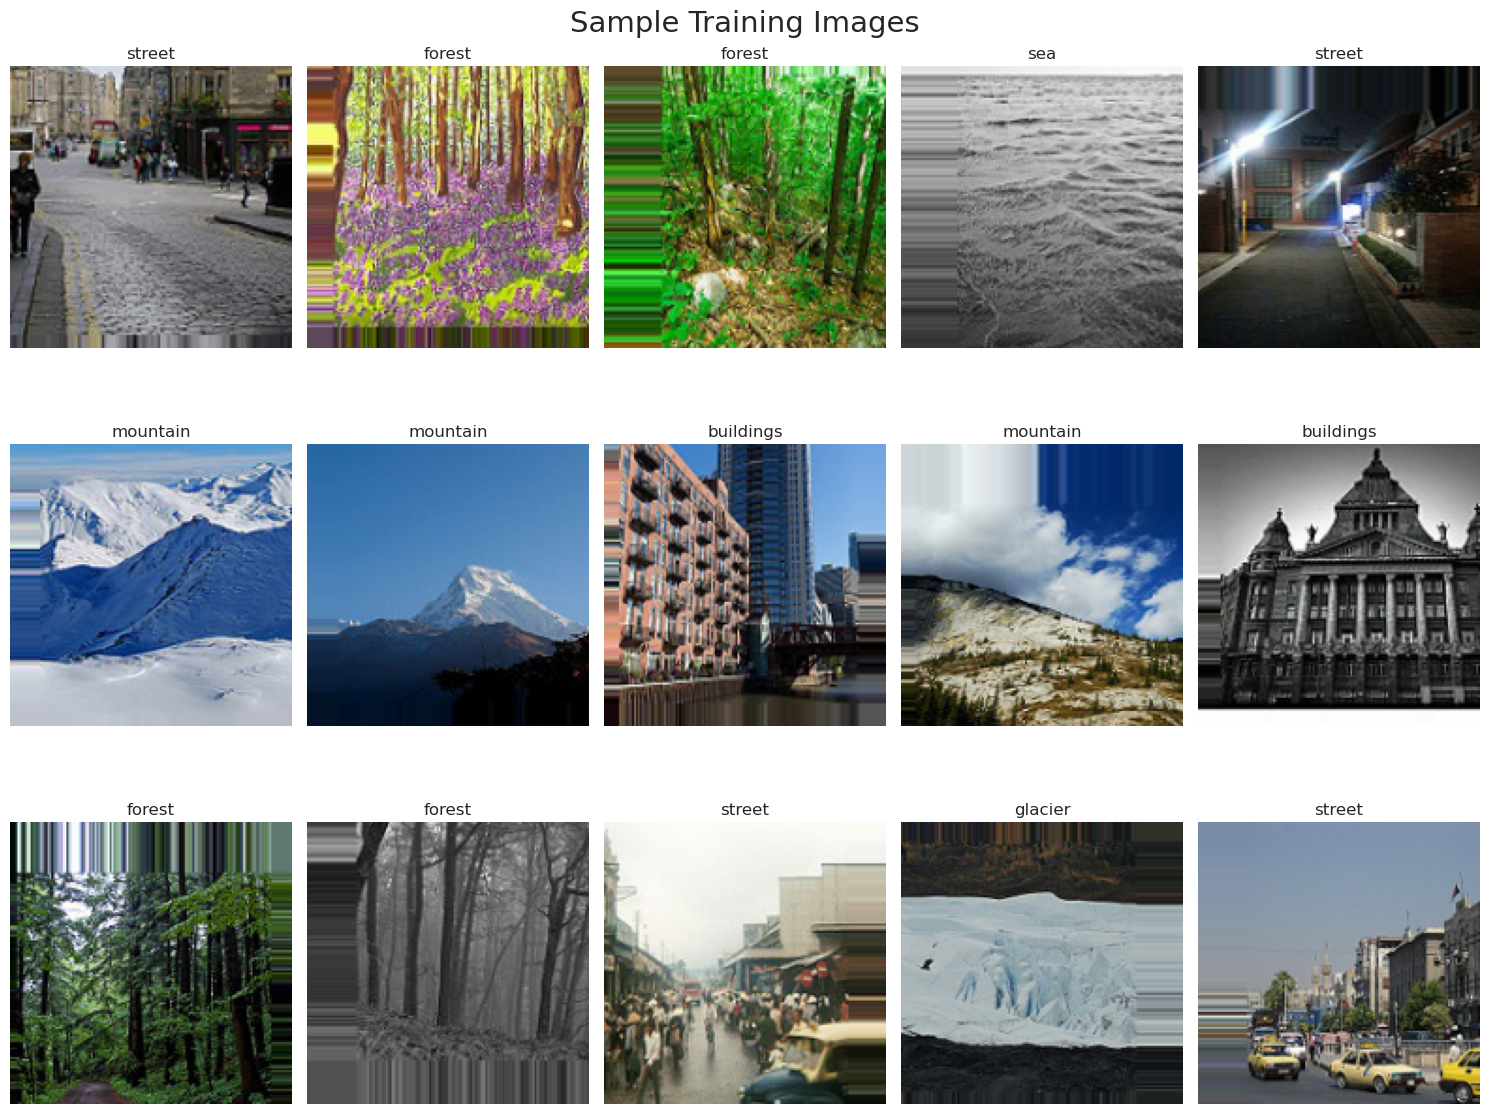

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 12))
idx = 0

for i in range(3):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

## Creating the model

In [10]:
model = Sequential([
    Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),

    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=6, activation='softmax')
])

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 activation (Activation)     (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

## Reducing Learning Rate on Plateau

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

## Defining the Optimizer

In [13]:
optimizer = Adam(learning_rate=0.001)

## Compiling the model

In [14]:
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [15]:
history = model.fit(train_generator, epochs=50, validation_data=validation_generator,
                    verbose=2,
                    callbacks=[reduce_lr])

Epoch 1/50
439/439 - 368s - loss: 2.0453 - accuracy: 0.5074 - val_loss: 1.2568 - val_accuracy: 0.5303 - lr: 0.0010 - 368s/epoch - 839ms/step
Epoch 2/50
439/439 - 361s - loss: 1.0613 - accuracy: 0.6165 - val_loss: 0.8445 - val_accuracy: 0.6790 - lr: 0.0010 - 361s/epoch - 823ms/step
Epoch 3/50
439/439 - 353s - loss: 0.8940 - accuracy: 0.6809 - val_loss: 0.8090 - val_accuracy: 0.7217 - lr: 0.0010 - 353s/epoch - 805ms/step
Epoch 4/50
439/439 - 349s - loss: 0.8128 - accuracy: 0.7027 - val_loss: 1.0312 - val_accuracy: 0.6540 - lr: 0.0010 - 349s/epoch - 796ms/step
Epoch 5/50
439/439 - 349s - loss: 0.7678 - accuracy: 0.7281 - val_loss: 0.8511 - val_accuracy: 0.7007 - lr: 0.0010 - 349s/epoch - 795ms/step
Epoch 6/50
439/439 - 353s - loss: 0.7263 - accuracy: 0.7418 - val_loss: 0.8225 - val_accuracy: 0.6820 - lr: 0.0010 - 353s/epoch - 803ms/step
Epoch 7/50
439/439 - 351s - loss: 0.6826 - accuracy: 0.7607 - val_loss: 0.6580 - val_accuracy: 0.7740 - lr: 0.0010 - 351s/epoch - 798ms/step
Epoch 8/50
43

KeyboardInterrupt: 